In [90]:
import numpy as np
import sympy
from sympy import symbols, Eq, linear_eq_to_matrix
import random
import matplotlib.pyplot as plt
from collections import deque, defaultdict
from pyeda.inter import expr, exprvar, expr2bdd
from dd.autoref import BDD
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import itertools
import pandas as pd
from sympy.logic.boolalg import SOPform

In [91]:
# from dd.cudd import BDD

F3 : a0 & a1
F2 : a1 & ~a0
F1 : (a0 & ~a1) | (a1 & ~a0)
F0 : a0
----------------------------------------------------------------------------------------------
number_of_nodes = 7


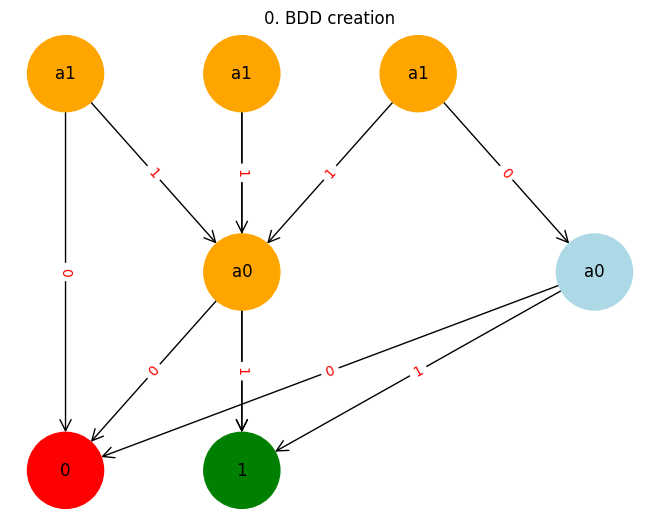

----------------------------------------------------------------------------------------------


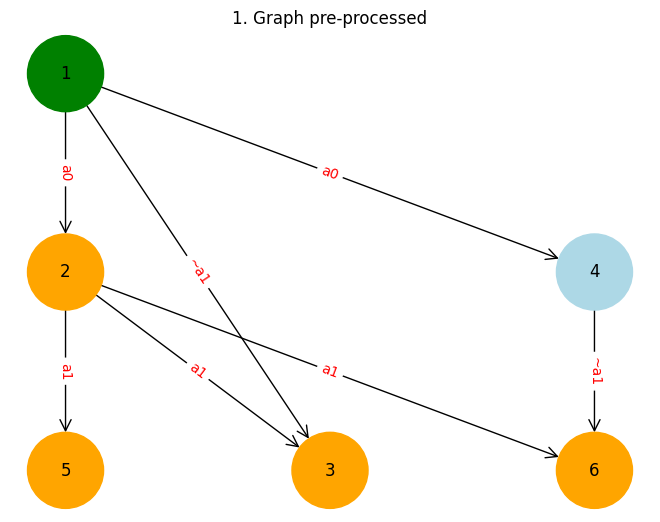

----------------------------------------------------------------------------------------------


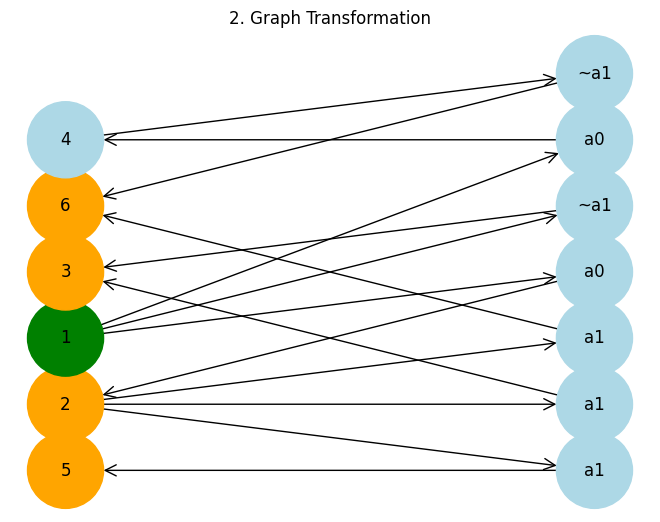

----------------------------------------------------------------------------------------------


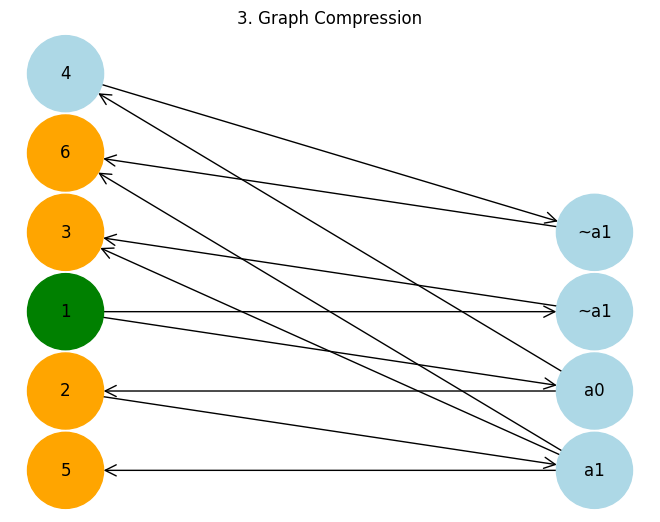

----------------------------------------------------------------------------------------------


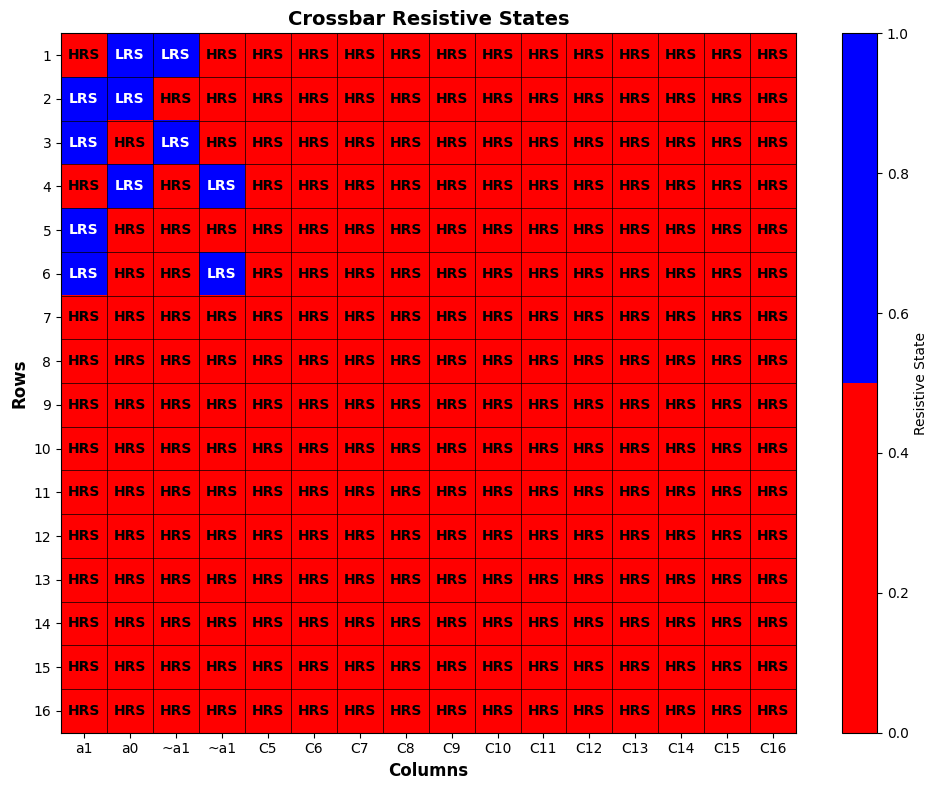

----------------------------------------------------------------------------------------------
Original Boolean Expression Truth Table:
  a1 a0 F3 F2 F1 F0
0  0  0  0  0  0  0
1  0  1  0  0  1  1
2  1  0  0  1  1  0
3  1  1  1  0  0  1

Evaluated Boolean Expression Truth Table:
   a1  a0  F3  F2  F1  F0
0   0   0   0   0   0   0
1   0   1   0   0   1   1
2   1   0   0   1   1   0
3   1   1   1   0   0   1

Ideal Path Evaluated Truth Table
   a1  a0  F3  F2  F1  F0
0   0   0   0   0   0   0
1   0   1   0   0   1   1
2   1   0   0   1   1   0
3   1   1   1   0   0   1


In [94]:
class PATH:
    def __init__(self, CrossbarGridSize = 16):
        self.CrossbarGridSize = CrossbarGridSize

        self.pre_bool_expressions = None
        self.pre_varibles_lst = None

        self.OriginalTruthTable = None
        self.TruthTable = None
        
        self.BDD = None
        self.Graph = None
        self.Expressions = None
        self.NodeIDMap = None
        self.InputNode = None
        self.GraphProcessPhase = None
        self.CrossbarResistiveStates = None

        self.xlabelsOfLiterals_map = {}
        self.OutputLine_Map = {}

    def TruthTable_to_BooleanExpression(self, df):

        # Need to validate
        self.OriginalTruthTable = df

        def get_minterm_index(row):
            minterm_str = ""
            for col in df.columns:
                if("F" not in col):
                    minterm_str = minterm_str + row[col]
            return int(minterm_str, 2)

        expressions = {}
        variables = [symbols(col) for col in df.columns if 'F' not in col]
        varibles_str_lst = []

        for col in df.columns:
            if('F' in col):
                minterms_col = [get_minterm_index(row) for idx, row in df.iterrows() if row[col] == '1']
                expressions[col] = str(SOPform(variables, minterms_col))
            else:
                varibles_str_lst.append(col)
        
        self.pre_varibles_lst = varibles_str_lst
        self.pre_bool_expressions = expressions

        for expression in expressions:
            print(expression,':',expressions[expression])

    def BooleanExpresions_to_BDD(self, variables=None, expressions=None):
        if(variables==None):
            if(self.pre_varibles_lst==None):
                print('error')
            else:
                variables = self.pre_varibles_lst
            
        if(expressions==None):
            if(self.pre_bool_expressions==None):
                print('error')
            else:
                expressions = self.pre_bool_expressions
        
        # Initialize the BDD manager
        self.BDD = BDD()
        # self.BDD.configure(reordering=True)
        
        # Declare variables
        self.BDD.declare(*variables)
        # self.BDD.declare('a', 'b', 'c', 'd')
        # self.BDD.declare('a0', 'b0', 'cin',)
        
        # Define Boolean expressions
        self.expressions = expressions
        # self.expressions = {
        #     'P0': 'a & b',
        #     'P1': '(a & b) ^ (c & d)',
        #     'P2': '(a & c) ^ ((a & b) & (c & d))',
        #     'P3': '(a & c) & ((a & b) & (c & d))'
        # }
        
        # self.expressions = {'c_out': '(a0 & b0) | (a0 & cin) | (b0 & cin)', 's_0': 'a0 ^ b0 ^ cin'}
        
        self.Expressions = {expression: self.BDD.add_expr(self.expressions[expression]) for expression in self.expressions}
        
        # self.BDD.collect_garbage()
        # self.BDD.reorder()
        
        number_of_nodes = len(self.BDD)
        print(f'{number_of_nodes = }')

    def BDD_to_NetworkXGraph(self):
        #Traversing the BDD
        ids_lsts = []
        self.NodeIDMap = {}
        for rootKey in self.Expressions:
            queue = [self.Expressions[rootKey]]
            id_lst = set()
            while(queue):
                curr_ele = queue.pop(0)
                [lvl, node1, node2] = self.BDD.succ(curr_ele)
        
                id_lst.add((str(curr_ele),curr_ele.var, curr_ele.negated))
                if(str(curr_ele) not in self.NodeIDMap):
                    self.NodeIDMap[str(curr_ele)]=[0,set()]
                self.NodeIDMap[str(curr_ele)][0]+=1
                self.NodeIDMap[str(curr_ele)][1].add((curr_ele.var, lvl))
                
                if node1.var!=None:
                    queue.append(node1)
                else:
                    if(str(node1) not in self.NodeIDMap):
                        self.NodeIDMap[str(node1)]=[0,{('0' if node1.negated else '1', 0)}]
                    self.NodeIDMap[str(node1)][0]+=1
                    
                    # print(node1,node1.negated)
                
                if node2.var!=None:
                    queue.append(node2)
                else:
                    if(str(node2) not in self.NodeIDMap):
                        self.NodeIDMap[str(node2)]=[0,{('0' if node2.negated else '1', 0)}]
                    self.NodeIDMap[str(node2)][0]+=1
                    
                    # print(node2,node2.negated)
            ids_lsts.append(id_lst)
        
        # Initialize an undirected graph
        self.Graph = nx.DiGraph()
        ExpressionsRev = {str(self.Expressions[key]):key for key in self.Expressions}
        
        #adding nodes
        for id in self.NodeIDMap:
            literal = next(iter(self.NodeIDMap[id][1]))[0]
            level = next(iter(self.NodeIDMap[id][1]))[1]
            ExpressionRoot = None
            if(id in ExpressionsRev):
                ExpressionRoot = ExpressionsRev[id]
            attributes = {'ID': id, 'literal': literal, 'level':level, 'ExpressionRoot': ExpressionRoot, 'BipartitePart':None}
        
            # Add nodes with attributes to the graph
            self.Graph.add_node(id, **attributes)
        
        # #Adding edges
        for rootKey in self.Expressions:
            queue = [self.Expressions[rootKey]]
            while(queue):
                curr_ele = queue.pop(0)
                [lvl, node1, node2] = self.BDD.succ(curr_ele)
                self.Graph.add_edge(str(curr_ele), str(node1), label='0')
                self.Graph.add_edge(str(curr_ele), str(node2), label='1')
                
                if node1.var!=None:
                    queue.append(node1)
                if node2.var!=None:
                    queue.append(node2)

        self.GraphProcessPhase = "0. BDD creation"

    def GraphPreprocessing(self):
        #Re-label the edges
        for u, v, data in self.Graph.edges(data=True):
            # Retrieve the parent node's literal
            parent_literal = self.Graph.nodes[u].get('literal')
            
            # Ensure the parent_literal is valid (not None) and the edge has a label
            if parent_literal and 'label' in data:
                # Update the edge label based on the parent node's literal
                if data['label'] == '0':
                    # For '0', add a negation (~) to the parent's literal
                    data['label'] = f"~{parent_literal}"
                elif data['label'] == '1':
                    # For '1', use the parent's literal directly
                    data['label'] = parent_literal

        # Remove the node with literal='0' and id='@-1' along with its connections
        nodes_to_remove = [node for node, data in self.Graph.nodes(data=True) if data.get('literal') == '0' and data.get('ID') == '@-1']
        for node in nodes_to_remove:
            self.Graph.remove_node(node)


        #Invert all edges in the graph 
        inverted_graph = nx.DiGraph()
        inverted_graph.add_nodes_from(self.Graph.nodes(data=True))
        inverted_graph.add_edges_from([(v, u, data) for u, v, data in self.Graph.edges(data=True)])
        self.Graph = inverted_graph

        # Store the root node (in RootNode) after inversion        
        self.InputNode = [node for node in self.Graph.nodes if self.Graph.nodes[node].get('literal')=='1' and self.Graph.in_degree(node) == 0][0]

        #Re-label the nodes
        Counter = 1
        queue = [self.InputNode]
        visited = set()
        while queue:
            current_node = queue.pop(0)

            if current_node in visited:
                continue
            visited.add(current_node)

            # Update node labels for the current node's
            self.Graph.nodes[str(current_node)]['literal'] = str(Counter)
            Counter+=1

            for _, target_node, edge_data in self.Graph.out_edges(str(current_node), data=True):
                queue.append(target_node)
        self.GraphProcessPhase = "1. Graph pre-processed"

    def GraphTransformation(self):
        # First mark all the old nodes with attribute as BipartitePart='U1'
        for node in self.Graph.nodes:
            self.Graph.nodes[node]['BipartitePart'] = 'U1'
    
        # Initialize a list to store new edges transformed into nodes
        new_nodes = []
        edge_counter = 1  # Counter for unique IDs for new nodes
    
        # Iterate through all edges in the graph
        for u, v, data in list(self.Graph.edges(data=True)):
            # Create a new node for the edge
            new_node_id = f"EdgeNode_{edge_counter}"
            edge_label = data.get('label', 'NoLabel')
            new_node_attributes = {
                'ID': new_node_id,
                'literal': edge_label,
                'BipartitePart': 'U2'
            }
    
            # Add the new node to the graph
            self.Graph.add_node(new_node_id, **new_node_attributes)
    
            # Connect the new node to the original source and target nodes
            self.Graph.add_edge(u, new_node_id, label='')
            self.Graph.add_edge(new_node_id, v, label='')
    
            # Remove the original edge
            self.Graph.remove_edge(u, v)
    
            # Keep track of the newly created node
            new_nodes.append(new_node_id)
    
            edge_counter += 1
    
        # Update the graph process phase
        self.GraphProcessPhase = "2. Graph Transformation"


    def GraphCompression(self):
        # Create a dictionary to store U2 node literals as keys and input node literals as values in a list
        compression_dict = {}

        # Iterate through all U2 nodes
        for node in self.Graph.nodes:
            if self.Graph.nodes[node].get('BipartitePart') == 'U2':
                # Get the literal of the current U2 node
                u2_literal = self.Graph.nodes[node].get('literal')
                u2_id = self.Graph.nodes[node].get('ID')

                # Collect input node literals (U1) connected to this U2 node
                if(u2_literal not in compression_dict):
                    compression_dict[u2_literal] = {}

                if(u2_id not in compression_dict[u2_literal]):
                    compression_dict[u2_literal][u2_id] = []
                
                for predecessor in self.Graph.predecessors(node):
                    if self.Graph.nodes[predecessor].get('BipartitePart') == 'U1':
                        compression_dict[u2_literal][u2_id].append(self.Graph.nodes[predecessor].get('literal'))

        # Merge U2 nodes with the same literal if they have the same input edges
        for u2_literal, nodes in compression_dict.items():
            merged_inputs = {}
            for node_id, inputs in nodes.items():
                inputs_tuple = tuple(sorted(inputs))  # Sort to handle duplicate edge inputs
                if inputs_tuple not in merged_inputs:
                    merged_inputs[inputs_tuple] = node_id
                else:
                    # Merge this node into the existing one
                    existing_node_id = merged_inputs[inputs_tuple]

                    # Redirect all outgoing edges from the current node to the existing node
                    for _, successor, edge_data in list(self.Graph.out_edges(node_id, data=True)):
                        self.Graph.add_edge(existing_node_id, successor, **edge_data)

                    # Remove the current node
                    self.Graph.remove_node(node_id)

        self.OutputLine_Map = {}
        for node in self.Graph.nodes:
            if self.Graph.nodes[node].get('ExpressionRoot') is not None:
                self.OutputLine_Map[self.Graph.nodes[node].get('literal')] = self.Graph.nodes[node].get('ExpressionRoot')
        

        # Update the graph process phase
        self.GraphProcessPhase = "3. Graph Compression"

    def CrossbarRelalization(self):
        self.CrossbarResistiveStates = [[0 for _ in range(self.CrossbarGridSize)] for _ in range(self.CrossbarGridSize)]

        self.colMap, counter = {}, 0
        for node in self.Graph.nodes:
            if(self.Graph.nodes[node]['BipartitePart']=='U2'):
                self.colMap[self.Graph.nodes[node]['ID']] = counter
                counter += 1
                
        for i,(u, v, data) in enumerate(self.Graph.edges(data=True)):
            if(self.Graph.nodes[u]['BipartitePart']=='U2'):
                row_i = int(self.Graph.nodes[v]['literal'])-1
                col_j = self.colMap[self.Graph.nodes[u]['ID']]
            else:
                row_i = int(self.Graph.nodes[u]['literal'])-1
                col_j = self.colMap[self.Graph.nodes[v]['ID']]
            self.CrossbarResistiveStates[row_i][col_j] = 1
            
        self.GraphProcessPhase = "4. Crossbar Realization"
    
    def DisplayEdgesInNetworkXGraph(self):
        # Iterate through all edges in the graph
        for i,(u, v, data) in enumerate(self.Graph.edges(data=True)):
            # Retrieve the edge label; default to 'No label' if not present
            edge_label = data.get('label', 'No label')
            print(f"{next(iter(self.NodeIDMap[u][1]))[0]}({u}) -[{edge_label}]-> {next(iter(self.NodeIDMap[v][1]))[0]}({v})")

    def VisuvaliseNetworkXGraph(self, bipartite=False):
        # Initialize position dictionary
        pos = {}
        
        # Parameters for positioning
        HORIZONTAL_SPACING = 1.0  # Horizontal distance between nodes
        VERTICAL_SPACING = 3.0    # Vertical distance between layers
        
        # Separate nodes into categories
        root_nodes = [node for node in self.Graph.nodes if self.Graph.in_degree(node) == 0]
        leaf_nodes = [node for node in self.Graph.nodes if self.Graph.out_degree(node) == 0]
        intermediate_nodes = [node for node in self.Graph.nodes if node not in root_nodes + leaf_nodes]

        if(bipartite):
            # Separate nodes by BipartitePart
            u1_nodes = [node for node in self.Graph.nodes if self.Graph.nodes[node].get('BipartitePart') == 'U1']
            u2_nodes = [node for node in self.Graph.nodes if self.Graph.nodes[node].get('BipartitePart') == 'U2']
    
            # Assign positions to U1 nodes (left column)
            for i, node in enumerate(u1_nodes):
                pos[node] = (0, (i * VERTICAL_SPACING))

            # Assign positions to U2 nodes (right column)
            for i, node in enumerate(u2_nodes):
                pos[node] = (2, (i * VERTICAL_SPACING))
                    
        else:
            # Assign positions to ExpressionRoot nodes (top layer)
            for i, node in enumerate(root_nodes):
                pos[node] = (i * HORIZONTAL_SPACING, 0)
                # print((i * HORIZONTAL_SPACING, 0))
            
            # Assign positions to Intermediate nodes based on BFS layers
            # Start BFS from all ExpressionRoot nodes
            layers = list(nx.bfs_layers(self.Graph, root_nodes))
            
            for lvl, nodes in enumerate(layers):
                # print("Layer:")
                for i, node in enumerate(nodes):
                    if node in intermediate_nodes:  # Only position intermediate nodes
                        # print(next(iter(idSet[node][1]))[0], end=",")
                        pos[node] = (i * HORIZONTAL_SPACING, -VERTICAL_SPACING * (lvl))
                        # print((i * HORIZONTAL_SPACING, -VERTICAL_SPACING * (lvl)))
                # print("\n")
    
            leafnodeYaxis = len(layers)
            if(self.Graph.nodes[layers[0][0]].get('literal')=="1"):
                leafnodeYaxis = leafnodeYaxis - 1
            
            # print("Literals")
            # Assign positions to Literal nodes (bottom layer)
            for i, node in enumerate(leaf_nodes):
                pos[node] = (i * HORIZONTAL_SPACING, -VERTICAL_SPACING * (leafnodeYaxis))
                # print((i * HORIZONTAL_SPACING, -VERTICAL_SPACING * (leafnodeYaxis)))
        
        # Draw nodes with labels
        node_colors = []
        for node in self.Graph.nodes:
            if self.Graph.nodes[node].get('ExpressionRoot') is not None:
                node_colors.append('orange')
            elif self.Graph.nodes[node].get('literal') == '0':
                node_colors.append('red')
            elif self.Graph.nodes[node].get('literal') == '1':
                node_colors.append('green')
            else:
                node_colors.append('lightblue')  # Default color for intermediate nodes

        nx.draw(self.Graph, pos, with_labels=False, node_color=node_colors, node_size=3000, font_size=10, arrows=True, arrowstyle='->', arrowsize=20)
        
        # Draw literals as node labels
        node_labels = nx.get_node_attributes(self.Graph, 'literal')
        nx.draw_networkx_labels(self.Graph, pos, labels=node_labels, font_size=12, font_color='black')
        
        # Draw edge labels
        edge_labels = nx.get_edge_attributes(self.Graph, 'label')
        nx.draw_networkx_edge_labels(self.Graph, pos, edge_labels=edge_labels, font_color='red')
        
        # Display the graph
        plt.title(self.GraphProcessPhase if self.GraphProcessPhase is not None else "Graph with Node Attributes and Edge Labels")
        plt.show()

    def VisuvaliseCrossbar(self):
        crossbar_matrix = np.array(self.CrossbarResistiveStates)
        
        colors = ["red", "blue"]
        custom_cmap = ListedColormap(colors)
        
        # Create the heatmap
        fig, ax = plt.subplots(figsize=(10, 8))
        heatmap = ax.imshow(crossbar_matrix, cmap=custom_cmap, aspect="auto")

        # Annotate the heatmap with 'LRS' or 'HRS'
        for i in range(crossbar_matrix.shape[0]):
            for j in range(crossbar_matrix.shape[1]):
                text = "LRS" if crossbar_matrix[i, j] == 1 else "HRS"
                ax.text(j, i, text, ha="center", va="center", 
                        color="white" if crossbar_matrix[i, j] == 1 else "black", 
                        fontsize=10, weight="bold")

        # Add gridlines for cell borders
        ax.set_xticks(np.arange(crossbar_matrix.shape[1] + 1) - 0.5, minor=True)
        ax.set_yticks(np.arange(crossbar_matrix.shape[0] + 1) - 0.5, minor=True)
        ax.grid(which="minor", color="black", linestyle="-", linewidth=0.5)
        ax.tick_params(which="minor", size=0)

        # Set labels and title
        ax.set_xlabel("Columns", fontsize=12, weight="bold")
        ax.set_ylabel("Rows", fontsize=12, weight="bold")
        ax.set_title("Crossbar Resistive States", fontsize=14, weight="bold")

        xlabelsOfLiterals = [f"C{i+1}" for i in range(crossbar_matrix.shape[0])]
        for col in self.colMap:
            xlabelsOfLiterals[self.colMap[col]] = self.Graph.nodes[col]['literal']

        #shif this to functional functions
        # xlabelsOfLiterals ['a1', 'a0', '~a1', '~a1', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16']
        self.xlabelsOfLiterals_map = {}
        for i,xlabelsOfLiteral in enumerate(xlabelsOfLiterals):
            
            only_label = xlabelsOfLiteral if xlabelsOfLiteral[0]!='~' else xlabelsOfLiteral[1:]
            negation = False if xlabelsOfLiteral[0]!='~' else True
            
            if(only_label not in self.xlabelsOfLiterals_map):
                self.xlabelsOfLiterals_map[only_label] = []
            self.xlabelsOfLiterals_map[only_label].append((i, negation))

        # Remove default ticks
        ax.set_xticks(np.arange(crossbar_matrix.shape[1]))
        ax.set_yticks(np.arange(crossbar_matrix.shape[0]))
        ax.set_xticklabels(xlabelsOfLiterals, fontsize=10)
        ax.set_yticklabels([f"{j+1}" for j in range(crossbar_matrix.shape[1])], fontsize=10)

        # Show the heatmap
        plt.colorbar(heatmap, label="Resistive State", orientation="vertical")
        plt.tight_layout()
        plt.show()

    def IdealCurrentPath(self, literal_value_map):
        
        # self.OutputLine_Map = {'5': 'F3', '2': 'F0', '3': 'F2', '6': 'F1'} #remove
        
        OutputPaths = {(Output_line-1, Output_line-1):[] for Output_line in self.OutputLine_Map}
        Resistance_matrix = self.CrossbarResistiveStates.copy()

        R_LRS = 1
        R_HRS = 0

        for label in self.xlabelsOfLiterals_map:
            col_i_lst, negation = self.xlabelsOfLiterals_map[label]
            for col_i in col_i_lst:
                for row_i in range(len(Resistance_matrix)):
                    if(literal_value_map[label]==1 and negation==True):
                        Resistance_matrix[row_i][col_i] = R_HRS
                    if(literal_value_map[label]==0 and negation==False):
                        Resistance_matrix[row_i][col_i] = R_HRS
        
        # Custom function to emulate an ordered set using a list
        def add_to_ordered_set(ordered_set, element):
            if element not in ordered_set:
                ordered_set.append(element)
        
        # Stack for depth-first traversal
        Stack = []
        
        # Finding paths
        for j in range(len(Resistance_matrix[0])):
            if Resistance_matrix[0][j] == R_LRS:
                Stack.append([(0, j), [(0, j)], 'w'])  # Use a list for ordered visited nodes
        
        while Stack:
            [(path_i, path_j), visited, last_curr] = Stack.pop()  # Pop from the stack (LIFO)
            for i in range(8):
                if last_curr == 'w':
                    if Resistance_matrix[i][path_j] == R_LRS and (i, path_j) not in visited:
                        new_visited = visited.copy()
                        add_to_ordered_set(new_visited, (i, path_j))
                        Stack.append([(i, path_j), new_visited, 'b'])
                elif last_curr == 'b':
                    if Resistance_matrix[path_i][i] == R_LRS and (path_i, i) not in visited:
                        new_visited = visited.copy()
                        add_to_ordered_set(new_visited, (path_i, i))
                        Stack.append([(path_i, i), new_visited, 'w'])
            if((path_i, path_j) in OutputPaths):
                OutputPaths[(path_i, path_j)] = visited
    
        return OutputPaths

    def GetTruthTables(self):
        variables = list(self.BDD.vars.keys())
        truth_table = []
        # Generate all combinations of variable assignments (0 and 1)
        for values in itertools.product([0, 1], repeat=len(variables)):
            assignment = dict(zip(variables, values))
            row = {var: val for var, val in assignment.items()}
            
            for expr_name, expr in self.expressions.items():
                # Evaluate the expression in the context of the current assignment
                row[expr_name] = eval(expr, {}, assignment)
            
            truth_table.append(row)

        print("Original Boolean Expression Truth Table:")
        print(self.OriginalTruthTable)
        print()
        self.TruthTable = pd.DataFrame(truth_table)
        print("Evaluated Boolean Expression Truth Table:")
        print(self.TruthTable)
        print()
        print("Ideal Path Evaluated Truth Table")
        print(self.TruthTable)


data = {
    'a1': ['0', '0', '1', '1'],
    'a0': ['0', '1', '0', '1'],
    # 'b1': ['1', '1', '1', '1'],
    # 'b0': ['1', '1', '1', '1'],
    'F3': ['0', '0', '0', '1'],
    'F2': ['0', '0', '1', '0'],
    'F1': ['0', '1', '1', '0'],
    'F0': ['0', '1', '0', '1']
}

df = pd.DataFrame(data)

path = PATH(CrossbarGridSize = 16)
path.TruthTable_to_BooleanExpression(df)
print("----------------------------------------------------------------------------------------------")
path.BooleanExpresions_to_BDD(variables=None, expressions=None)
path.BDD_to_NetworkXGraph()
path.VisuvaliseNetworkXGraph()
print("----------------------------------------------------------------------------------------------")
path.GraphPreprocessing()
path.VisuvaliseNetworkXGraph()
print("----------------------------------------------------------------------------------------------")
path.GraphTransformation()
path.VisuvaliseNetworkXGraph(bipartite=True)
print("----------------------------------------------------------------------------------------------")
path.GraphCompression()
path.VisuvaliseNetworkXGraph(bipartite=True)
print("----------------------------------------------------------------------------------------------")
path.CrossbarRelalization()
path.VisuvaliseCrossbar()
print("----------------------------------------------------------------------------------------------")
path.GetTruthTables()

In [95]:
path.OutputLine_Map

{'5': 'F3', '2': 'F0', '3': 'F2', '6': 'F1'}

In [36]:
data = {
    'a1': ['0', '0', '1', '1'],
    'a0': ['0', '1', '0', '1'],
    # 'b1': ['1', '1', '1', '1'],
    # 'b0': ['1', '1', '1', '1'],
    'F3': ['0', '0', '0', '1'],
    'F2': ['0', '0', '1', '0'],
    'F1': ['0', '1', '1', '0'],
    'F0': ['0', '1', '0', '1']
}

df = pd.DataFrame(data)
df

,a1,a0,F3,F2,F1,F0
0,0,0,0,0,0,0
1,0,1,0,0,1,1
2,1,0,0,1,1,0
3,1,1,1,0,0,1


In [3]:
def idealCurrentPath(Resistance_matrix, Output_cells):
    
    OutputPaths = {Output_cell:[] for Output_cell in Output_cells}

    # Custom function to emulate an ordered set using a list
    def add_to_ordered_set(ordered_set, element):
        if element not in ordered_set:
            ordered_set.append(element)
    
    # Stack for depth-first traversal
    Stack = []
    
    # Finding paths
    for j in range(len(Resistance_matrix[0])):
        if Resistance_matrix[0][j] == R_LRS:
            Stack.append([(0, j), [(0, j)], 'w'])  # Use a list for ordered visited nodes
    
    while Stack:
        [(path_i, path_j), visited, last_curr] = Stack.pop()  # Pop from the stack (LIFO)
        for i in range(8):
            if last_curr == 'w':
                if Resistance_matrix[i][path_j] == R_LRS and (i, path_j) not in visited:
                    new_visited = visited.copy()
                    add_to_ordered_set(new_visited, (i, path_j))
                    Stack.append([(i, path_j), new_visited, 'b'])
            elif last_curr == 'b':
                if Resistance_matrix[path_i][i] == R_LRS and (path_i, i) not in visited:
                    new_visited = visited.copy()
                    add_to_ordered_set(new_visited, (path_i, i))
                    Stack.append([(path_i, i), new_visited, 'w'])
        if((path_i, path_j) in OutputPaths):
            OutputPaths[(path_i, path_j)] = visited

    return OutputPaths

# idealCurrentPath(Resitance_matrix, Output_cells)

In [53]:
def ValidatePathCurrent(literals, col_mappings, high_resitivity = 2e9):
    # Resistor parameters
    R_Off       = 1e9    # Very large (transistor off)
    R_HRS       = high_resitivity    # High-resistance state of the memory cell
    R_LRS       = 5000    # Low-resistance state (example, or swap values as needed)
    R_Line_Out  = 2e2    # 200 ohms from each column node to GND (example)
    R_Not       = 1e9
    
    # Resitance matrix
    Resitance_matrix = [
          #1       2      3     4      5      6      7      8
        [R_LRS, R_HRS, R_HRS, R_HRS, R_LRS, R_HRS, R_HRS, R_HRS],
        [R_HRS, R_HRS, R_LRS, R_HRS, R_LRS, R_HRS, R_HRS, R_HRS],
        [R_HRS, R_LRS, R_LRS, R_HRS, R_HRS, R_LRS, R_HRS, R_HRS],
        [R_LRS, R_HRS, R_HRS, R_LRS, R_HRS, R_LRS, R_HRS, R_HRS],
        [R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS],
        [R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS],
        [R_LRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_LRS, R_HRS],
        [R_HRS, R_HRS, R_LRS, R_HRS, R_HRS, R_HRS, R_HRS, R_LRS],
    ]
    
    #Close transistor gate connected to uncharged selector lines
    # Selector_lines = {1:1, 2:1, 3:1, 4:1, 5:0, 6:0, 7:1, 8:1}
    # literals = {'a0':0, 'a1':0}
    # col_mappings = ['a0', 1, 'a1', 'a1', '~a0', '~a1', 1, 1]
    Selector_lines = {}
    for i, col_mapping in enumerate(col_mappings):
        if(col_mapping==1):
            Selector_lines[i+1] = 1
            continue
        negation = False
        if(col_mapping[0]=="~"):
            negation = True
            label = col_mapping[1:]
        else:
            label = col_mapping

        if(negation and literals[label]==1):
            Selector_lines[i+1] = 0
        elif(negation==False and literals[label]==0):
            Selector_lines[i+1] = 0
        else:
            Selector_lines[i+1] = 1
    
    for j in Selector_lines:
        for i in range(len(Resitance_matrix)):
            if(Selector_lines[j]!=1):
                Resitance_matrix[i][j-1] = R_Off
                
    
    #Output lines
    Output_lines_cells = {'F1':(2, (2, 2-1)), 'F3':(4, (3 ,4-1)), 'F0':(7, (6, 7-1)), 'F2':(8, (7, 8-1))}
    
    Output_cells = {Output_cell for _,Output_cell in Output_lines_cells.values()}
    Output_cells_map = {Output_lines_cells[key][1]:key for key in Output_lines_cells}
    
    Output_lines = {Output_line for Output_line,_ in Output_lines_cells.values()}
    Output_lines_map = {Output_lines_cells[key][0]:key for key in Output_lines_cells}
    
    OutputPaths = idealCurrentPath(Resitance_matrix, Output_cells)
    
    AllOutputPaths =  [item for sublist in OutputPaths.values() for item in sublist]
    AllLRS =  [(row_i, row_j) for row_i, row in enumerate(Resitance_matrix) for row_j, val in enumerate(row) if val==R_LRS]
    
    # 1. row voltages and column voltages as symbolic variables
    Vr = sympy.symbols('Vr1 Vr2 Vr3 Vr4 Vr5 Vr6 Vr7 Vr8', real=True)
    Vc = sympy.symbols('Vc1 Vc2 Vc3 Vc4 Vc5 Vc6 Vc7 Vc8', real=True)
    
    # Voltages together in a single list for convenience
    x_vars = list(Vr) + list(Vc)
    
    #Voltage source
    Vsrc = 0.2
    
    # 2. Build the 16 KCL equations (8 row and 8 column equations to find their voltage)
    equations = []
    
    for i in range(8):
        if(i==0):   #First wordline connected to voltage source
            eq_i = sympy.Eq(Vr[i], Vsrc)
        else:
            row_crossbar_sum = 0
            for j in range(8):
                row_crossbar_sum += 1/Resitance_matrix[i][j] * (Vr[i] - Vc[j])
            eq_i = sympy.Eq(row_crossbar_sum, 0)
        equations.append(eq_i)
    
    for j in range(8):
        if(j+1 in Output_lines):
            col_to_ground = Vc[j] / R_Line_Out
        else:
            col_to_ground = Vc[j] / R_Not
            
        col_crossbar_sum = 0
        for i in range(8):
            col_crossbar_sum += 1/Resitance_matrix[i][j] * (Vc[j] - Vr[i])
        eq_j = sympy.Eq(col_to_ground + col_crossbar_sum, 0)
        equations.append(eq_j)
    
    # ----------------------------------------------------------------
    # 3) Solve the system A*x = b
    A, b = sympy.linear_eq_to_matrix(equations, x_vars)
    solution = A.LUsolve(b)
    
    Voltages = {}
    
    for var, val in zip(x_vars, solution):
        Voltages[f"{var}"] = val.evalf()*1000
        
    currentInDevices = [[0 for _ in range(8)] for _ in range(8)]
    for i in range(8):
        for j in range(8):
            currentInDevices[i][j] = (Voltages['Vr'+str(i+1)]-Voltages['Vc'+str(j+1)])/Resitance_matrix[i][j]
    
    Outputs_map = {}
    
    for key in OutputPaths:
        output_label = Output_cells_map[key]
        Outputs_map[output_label] = OutputPaths[key]
    
    Output_current_map = {}
    for Output_line in Output_lines:
        output_label = Output_lines_map[Output_line]
        Output_current_map[output_label] = Voltages['Vc'+str(Output_line)] / R_Line_Out
    
    return Output_current_map

In [54]:
col_mappings = ['a0', 1, 'a1', 'a1', '~a0', '~a1', 1, 1] #fixed
literals = {'a0':1, 'a1':1}
print(ValidatePathCurrent(literals, col_mappings, high_resitivity = 2e9))
df

{'F2': 4.63894915983169e-7, 'F1': 4.63894915983169e-7, 'F3': 0.00990095928256220, 'F0': 0.00990095928256220}


,a1,a0,F3,F2,F1,F0
0,0,0,0,0,0,0
1,0,1,0,0,1,1
2,1,0,0,1,1,0
3,1,1,1,0,0,1


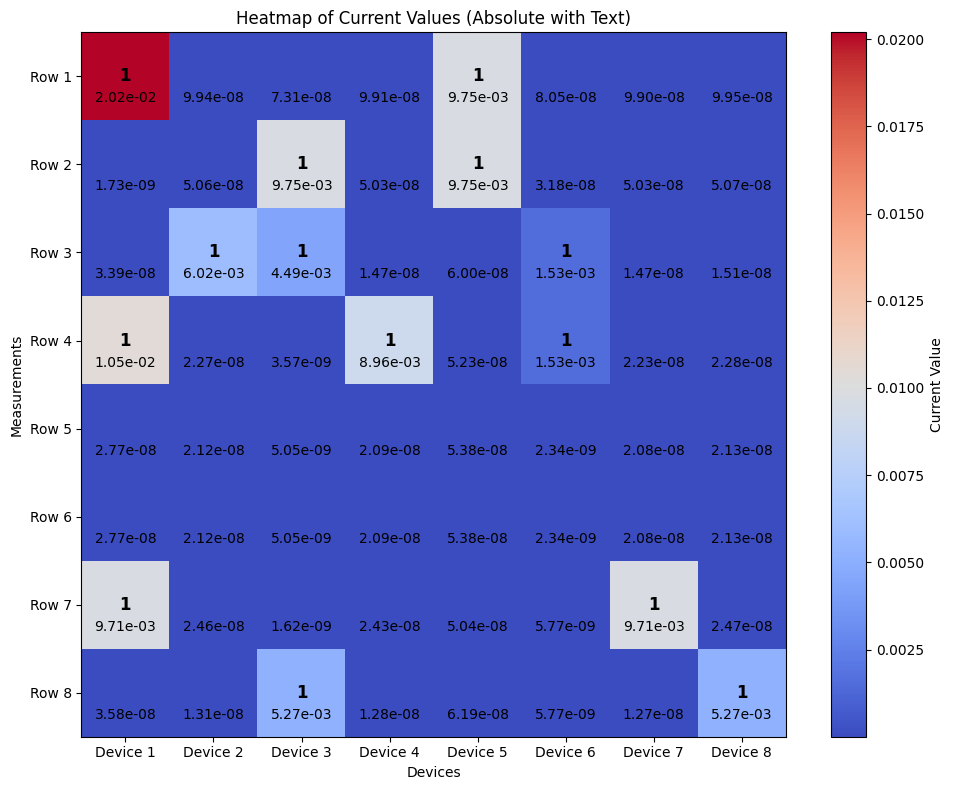

In [17]:
# Converting all numbers in currentInDevices to their absolute values
currentInDevices_abs = [[abs(value) for value in row] for row in currentInDevices]

# Convert to a numeric numpy array
data = np.array(currentInDevices_abs, dtype=float)

# Re-plotting the heatmap with absolute values and displaying text on each cell
plt.figure(figsize=(10, 8))
plt.imshow(data, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Current Value')

# Add text annotations on each cell
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        # if((i,j) in AllOutputPaths):
        if((i,j) in AllLRS):
            plt.text(j, i, "1", ha='center', va='center', color='black', fontsize=12, fontweight='bold')
        plt.text(j, i+0.25, f"{data[i, j]:.2e}", ha='center', va='center', color='black')

# Add labels and title
plt.title("Heatmap of Current Values (Absolute with Text)")
plt.xlabel("Devices")
plt.ylabel("Measurements")
plt.xticks(ticks=np.arange(data.shape[1]), labels=[f"Device {i+1}" for i in range(data.shape[1])])
plt.yticks(ticks=np.arange(data.shape[0]), labels=[f"Row {i+1}" for i in range(data.shape[0])])

# Show the plot
plt.tight_layout()
plt.show()

In [83]:
guard_values = []
resistance_values = []
lower_bound=0
upper_bound=2e9

for i in range(30):
    resitance_value = (lower_bound + upper_bound) / 2
    
    #Iterate over the DataFrame and validate each row
    zeroLiteralCurrents, oneLiteralCurrents = [], []
    for index, row in df.iterrows():
        literals = {'a0': int(row['a0']), 'a1': int(row['a1'])}
        results = ValidatePathCurrent(literals, col_mappings, high_resitivity = resitance_value)
        for result_current_label in results:
            if(row[result_current_label]=='0'):
                zeroLiteralCurrents.append(results[result_current_label])
            if(row[result_current_label]=='1'):
                oneLiteralCurrents.append(results[result_current_label])
                
    guardValue = min(oneLiteralCurrents) - max(zeroLiteralCurrents)

    # Binary search adjustment based on guard value
    flag=False
    if guardValue > 0:
        upper_bound = resitance_value
        flag=True
    else:
        lower_bound = resitance_value

    if(flag):
        guard_values.append(guardValue)
        resistance_values.append(resitance_value)

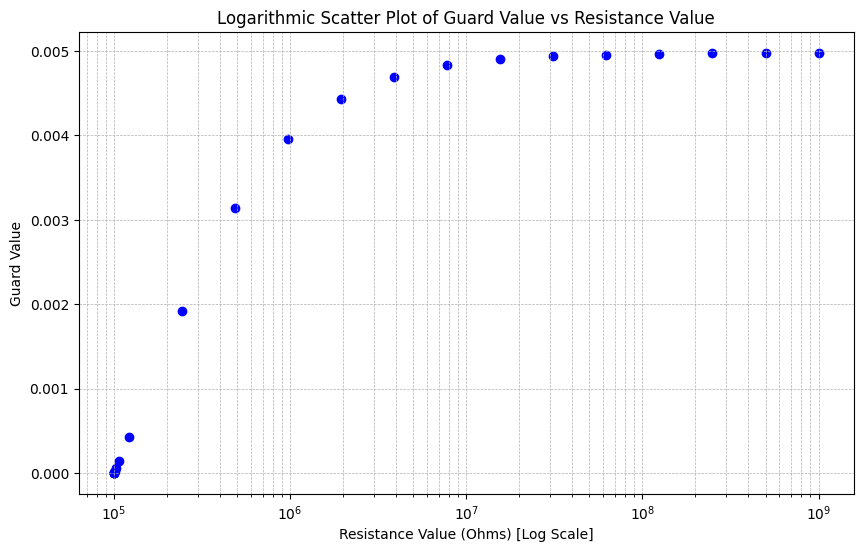

1000000000.0 : 0.00497377866206750
500000000.0 : 0.00497265553792542
250000000.0 : 0.00497040845485176
125000000.0 : 0.00496591648346043
62500000.0 : 0.00495694512774820
31250000.0 : 0.00493905488155916
15625000.0 : 0.00490348409187490
7812500.0 : 0.00483317077052718
3906250.0 : 0.00469577030681147
1953125.0 : 0.00443321510115970
976562.5 : 0.00395236216905655
488281.25 : 0.00313694559467251
244140.625 : 0.00192183095117246
122070.3125 : 0.000430506190575926
106811.5234375 : 0.000138644058924184
102996.826171875 : 0.0000600085640899417
101089.4775390625 : 0.0000197744616144734
100612.64038085938 : 0.00000961833324486950
100374.22180175781 : 0.00000452548992099528
100255.01251220703 : 0.00000197536235999485
100195.40786743164 : 6.99370712205563E-7
100165.60554504395 : 6.11427472272177E-8
100163.74289989471 : 2.12483591884721E-8


In [85]:
# Plotting the scatter plot with a logarithmic x-axis
plt.figure(figsize=(10, 6))
plt.scatter(resistance_values, guard_values, color='blue', marker='o')

# Adding labels and title with logarithmic scale for the x-axis
plt.xscale('log')
plt.xlabel('Resistance Value (Ohms) [Log Scale]')
plt.ylabel('Guard Value')
plt.title('Logarithmic Scatter Plot of Guard Value vs Resistance Value')

# Display the plot
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

# Display resistance values with corresponding guard values
for i in range(len(resistance_values)):
    print(f"{resistance_values[i]} : {guard_values[i]}")

In [15]:
# Binary search implementation for resistance values with added safeguards
def binary_search_guard_value(df, col_mappings, iterations=10, lower_bound=0, upper_bound=2e9):
    guardValues = []
    resistance_values = []

    for _ in range(iterations):
        resitance_value = (lower_bound + upper_bound) / 2

        # Iterate over the DataFrame and validate each row
        zeroLiteralCurrents, oneLiteralCurrents = [], []
        for index, row in df.iterrows():
            literals = {'a0': int(row['a0']), 'a1': int(row['a1'])}
            
            # Mocking ValidatePathCurrent for demonstration
            def ValidatePathCurrent(literals, col_mappings, high_resitivity):
                return {
                    'F2': (4.63894915983169e-7 / high_resitivity) if literals.get('a1') == 1 and literals.get('a0') == 0 else (0.00990095928256220 / high_resitivity),
                    'F1': (4.63894915983169e-7 / high_resitivity) if literals.get('a1') == 1 and literals.get('a0') == 0 else (0.00990095928256220 / high_resitivity),
                    'F3': (0.00990095928256220 / high_resitivity) if literals.get('a1') == 1 and literals.get('a0') == 1 else (4.63894915983169e-7 / high_resitivity),
                    'F0': (0.00990095928256220 / high_resitivity) if literals.get('a1') == 1 and literals.get('a0') == 1 else (4.63894915983169e-7 / high_resitivity)
                }

            results = ValidatePathCurrent(literals, col_mappings, high_resitivity=resitance_value)

            for result_current_label in results:
                if int(row[result_current_label]) == 0:
                    zeroLiteralCurrents.append(results[result_current_label])
                if int(row[result_current_label]) == 1:
                    oneLiteralCurrents.append(results[result_current_label])

        # Safeguard against empty sequences
        if oneLiteralCurrents and zeroLiteralCurrents:
            guardValue = min(oneLiteralCurrents) - max(zeroLiteralCurrents)
        else:
            guardValue = 0  # Default value if lists are empty

        guardValues.append(guardValue)
        resistance_values.append(resitance_value)

        # Binary search adjustment based on guard value
        if guardValue > 0:
            lower_bound = resitance_value
        else:
            upper_bound = resitance_value

    return resistance_values, guardValues

# Example column mappings
col_mappings = ['a0', 1, 'a1', 'a1', '~a0', '~a1', 1, 1]

# Run binary search for 10 iterations
resistance_values, guardValues = binary_search_guard_value(df, col_mappings)

# Display the results
results_df = pd.DataFrame({'Resistance Value (Ohms)': resistance_values, 'Guard Value': guardValues})
tools.display_dataframe_to_user("Binary Search Guard Values", results_df)


{'Vr1': 200.000000000000,
 'Vr2': 102.474230318114,
 'Vr3': 31.2832817582807,
 'Vr4': 46.5815590596079,
 'Vr5': 43.6115644434861,
 'Vr6': 43.6115644434861,
 'Vr7': 50.4809804626452,
 'Vr8': 27.3836614049315,
 'Vc1': 99.0204758582272,
 'Vc2': 1.20325177154904,
 'Vc3': 53.7137314017327,
 'Vc4': 1.79164518534709,
 'Vc5': 151.235906490757,
 'Vc6': 38.9326155352903,
 'Vc7': 1.94162245572715,
 'Vc8': 1.05326684925819}